# Studies about gravitational waves, glitches on O3 run data - We need be able to obtain data from LIGO, HANFORD and VIRGO interferometers, manipulate this data and plot the results from O3 run.

## 1 Introduction

First we need import the necessary libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import gwpy

import seaborn as sns
import warnings
import math
import numpy as np
import datetime
import matplotlib.dates as mdates

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

from astropy.time import Time
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

import frequency_functions as ff

We can collect data in two main ways:

1 - from LigoDV-web (H1, L1, V1 - https://login.ligo.org/idp/profile/SAML2/Redirect/SSO?execution=e1s2) that **need of your LIGO credentials**.

2 - from Zenodo website (H1, L1 - https://zenodo.org/records/5649212) that **does't have V1 data**.

A brief explanation of how to import this data across websites can be found at - **???**.

## 2 Clean the data and filter interesting features

You can make this all process with any interferometers. In our case is V1 from LigoDV-web.

### 2.1 To see the data in dataFrame mode, use pandas libraries

* **The O3 run have some duplicates data, depending on the source you got the data. This happens because some sources get data from multiple interferometers, or because the data have overlapping data segments in time windows. Furthermore, during data cleaning or combining different glitch catalogs (e.g., Gravity Spy + Omicron), indentical glitches might be added more than once. So, we use df.drop_duplicates()**

In [11]:
dfligo_V1_O3a = pd.read_csv("O3run data/V1_O3a_gspyLIGO.csv").drop_duplicates()
dfligo_V1_O3b = pd.read_csv("O3run data/V1_O3b_gspyLIGO.csv").drop_duplicates()

dfligo_V1_O3a.tail()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,id,ifo,label,imgUrl,Q-value
80393,1.253167e+09,21.276,7.905,1.460000e-21,3680.246,2.013,7328.491699,0.0,0.0,0.187,axFS82a5rf,V1,Light_Modulation,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
80394,1.253478e+09,19.950,7.959,1.800000e-21,42.988,0.500,53.975620,0.0,0.0,0.184,aH3vyF6Rc1,V1,None_of_the_Above,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
80395,1.244633e+09,418.816,8.968,2.010000e-22,302.104,0.359,547.768860,0.0,0.0,0.177,fgQ0bycRBj,V1,None_of_the_Above,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
80396,1.240533e+09,116.576,10.334,1.270000e-22,109.385,0.375,182.753067,0.0,0.0,0.172,vmTmg3Y2x0,V1,Scratchy,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,11.314
80397,1.241687e+09,349.985,8.376,1.570000e-22,324.817,0.703,600.853760,0.0,0.0,0.161,0o9ovV7MEB,V1,Koi_Fish,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627


### 2.2 To only filter glitches that have confidence vales above 90%

* **The reason why pipelines like Gravity Spy have relatively few glitches classified with confidence above 90% is due to a combination of factors. Glitches are highly diverse and often ambiguous, making them hard to classify with certainty. The machine learning models used are cautious and assign high confidence only when the classification is very clear. Additionally, the training data may be imbalanced, with some glitch types being rare or underrepresented. Visual similarities between categories can also reduce confidence. As a result, most confidence scores tend to fall below the 90% threshold, which is expected in complex multi-class classification problems.**

A lot glitches have no high confidence from its pipeline classification, see

In [15]:
above_90percent = (dfligo_V1_O3a['confidence'] >= 0.9).sum()
total = len(dfligo_V1_O3a)

percent = above_90percent / total
percent

0.5745789696261101

So lets only filter this nice glitches confidence for our analysis. The length of our data was decreased, see

In [17]:
clean_V1_O3a = dfligo_V1_O3a[dfligo_V1_O3a['confidence'] >= 0.9]
clean_V1_O3b = dfligo_V1_O3b[dfligo_V1_O3b['confidence'] >= 0.9]

clean_V1_O3a.shape

(46195, 15)

## 3 Analyze the frequency of each categorized glitch of O3 in general, but also splitting the analysis for O3a (April 1st 2019 - October 1st 2019) and O3b (November 1st 2019 - March 27th 2020) runs

### 3.1 The dominance of each glitch in O3a run

* **During the O3a and O3b observing runs, there was a clear dominance of certain glitch types, both in quantity and persistence over time. Blip glitches were especially prevalent during O3a, appearing frequently and relatively uniformly across different months. Other commonly observed types included scattered light, often associated with nighttime or seismic activity, and power line glitches, which are linked to persistent electrical noise. In contrast, categories such as low-frequency burst or 1400 ripple were much rarer and more localized, making statistical analysis and classifier training more difficult. This imbalance in glitch occurrence reflects both instrumental and environmental conditions that influence detector sensitivity and the nature of noise sources during different phases of the observation run.**

To count each glitch that we have, we use the **.value_counts()** function in the column **"label"** of our data

* If you prefer, the function **.nlargest(m)** after **.value_counts()** select the **"m"** biggest

In [22]:
glitch_countsO3a = clean_V1_O3a['label'].value_counts().sort_values(ascending=True)

In [23]:
glitch_countsO3a.head()

1080Lines             2
1400Ripples           4
Paired_Doves         67
Light_Modulation    103
Power_Line          119
Name: label, dtype: int64

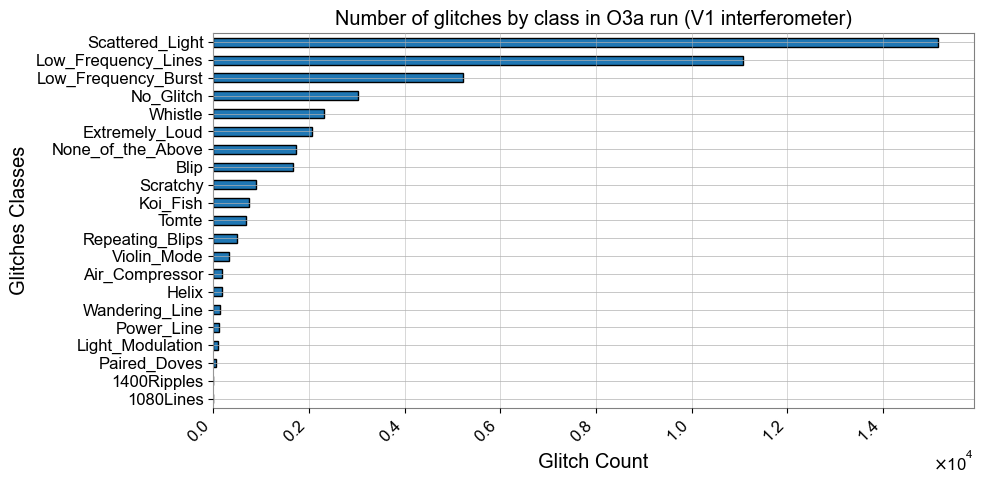

In [24]:
plt.figure(figsize=(10, 5))
glitch_countsO3a.plot(kind='barh', edgecolor='black')

plt.title('Number of glitches by class in O3a run (V1 interferometer)')
plt.xlabel('Glitch Count')
plt.ylabel('Glitches Classes')
plt.xticks(rotation=45, ha='right')  # Rotaciona os nomes dos glitches

plt.grid(axis='x', linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.2 And for O3b run we have

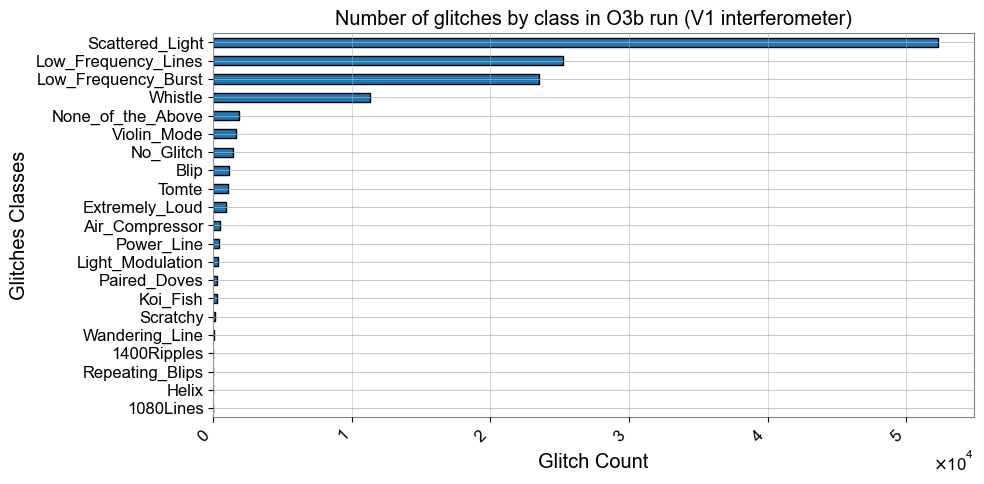

In [26]:
glitch_countsO3b = clean_V1_O3b['label'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(10, 5))
glitch_countsO3b.plot(kind='barh', edgecolor='black')

plt.title('Number of glitches by class in O3b run (V1 interferometer)')
plt.xlabel('Glitch Count')
plt.ylabel('Glitches Classes')
plt.xticks(rotation=45, ha='right')  # Rotaciona os nomes dos glitches

plt.grid(axis='x', linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

We can see that **scattering-light** (and **fast-scattering** inside it) are the glitches that occurred the most during the O3b run - around November 1st 2019 - March 27th 2020. This agreed with Tabata teses (https://www.gov.br/inpe/pt-br/area-conhecimento/posgraduacao/ast/repositorio-de-arquivos/teses/tese_tabata_aira_ferreira.pdf)

## 4 Time-tracking of the incidence of each glitch category throughout O3 (by monthly, season, …)

In [29]:
clean_V1_O3a = clean_V1_O3a.sort_values(by='GPStime', ascending=True)
clean_V1_O3b = clean_V1_O3b.sort_values(by='GPStime', ascending=True)

clean_V1_O3a = clean_V1_O3a.reset_index(drop=True)
clean_V1_O3b = clean_V1_O3b.reset_index(drop=True)

print(clean_V1_O3a.index)
clean_V1_O3a.head()

RangeIndex(start=0, stop=46195, step=1)


,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,id,ifo,label,imgUrl,Q-value
0,1.238166e+09,118.526,12.088,1.090000e-22,211.877,0.094,331.946350,0.0,0.0,1.000,U9hF0CFicL,V1,Blip,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,5.657
1,1.238167e+09,19.950,7.867,2.590000e-21,20.195,0.750,8.390090,0.0,0.0,0.998,cFEXeEnnvv,V1,Low_Frequency_Lines,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
2,1.238167e+09,41.312,8.180,2.460000e-22,65.530,0.078,82.279373,0.0,0.0,1.000,7Rmzlmneu5,V1,Blip,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,5.657
3,1.238167e+09,19.056,8.306,3.290000e-21,19.370,1.750,2.439150,0.0,0.0,0.965,pwXEfq8DlK,V1,Low_Frequency_Lines,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,45.255
4,1.238168e+09,340.202,12.113,1.970000e-22,357.194,0.313,218.644699,0.0,0.0,1.000,wiP1dmnUtc,V1,Whistle,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,45.255


## 4.1 plot the simple data 

vamos escolher os nossos glitches e a chave temporal, i.e., em que intervalo queremos subdividir o eixo x

In [32]:
# some glitches that you can use
'''
    Scattered_Light            Koi_Fish
    Low_Frequency_Lines        Tomte
    Low_Frequency_Burst        Violin_Mode
                               Blip 
'''

init_data_O3a = clean_V1_O3a.copy()
init_data_O3b = clean_V1_O3b.copy()

glitches_number = 4
glitches_chosen = ['Scattered_Light', 'Low_Frequency_Lines', 'Low_Frequency_Burst', 'Koi_Fish']

# some keys that you can use
'''
    'd', 'daily',
    'w', 'weekly',
    'm', 'monthly',
    'q', 'quarterly',
    '2q', 'half-yearly',
    'y', 'annual'
'''

time_key = 'd'

Para verificar se as entradas escolhidas para nosso plot estão de acordo com o dataFrame que contém os glitches, vamos criar uma função de verificação de dependencias, i.e., uma função que verifica se ambos os nomes dos glitches e a chave temporal escolhidos, são válidos.

In [34]:
ff.inputs_dependences(init_data_O3a, glitches_number, glitches_chosen, time_key)

All chosen names are valid.


agora plotamos o gráfico, de acordo com as entradas escolhidas

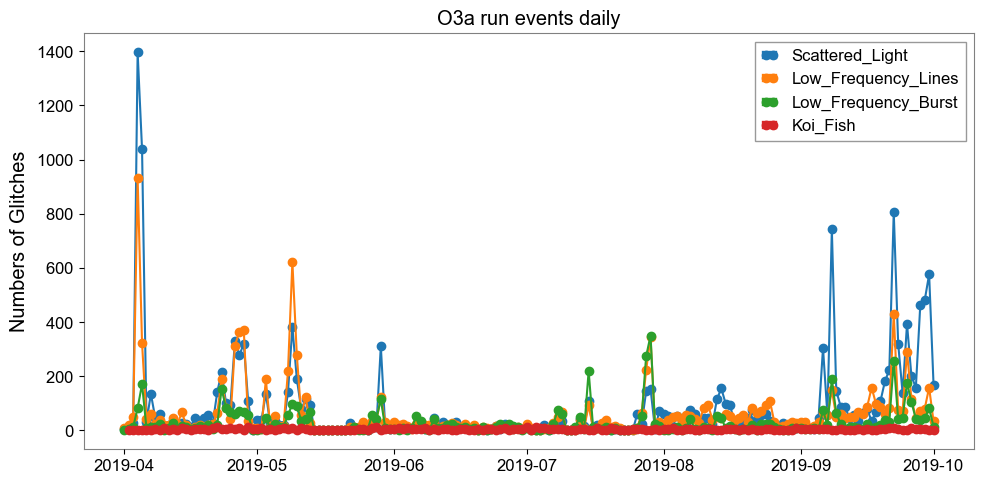

In [36]:
ff.plot_function(init_data_O3a, glitches_number, glitches_chosen, time_key, run='O3a')

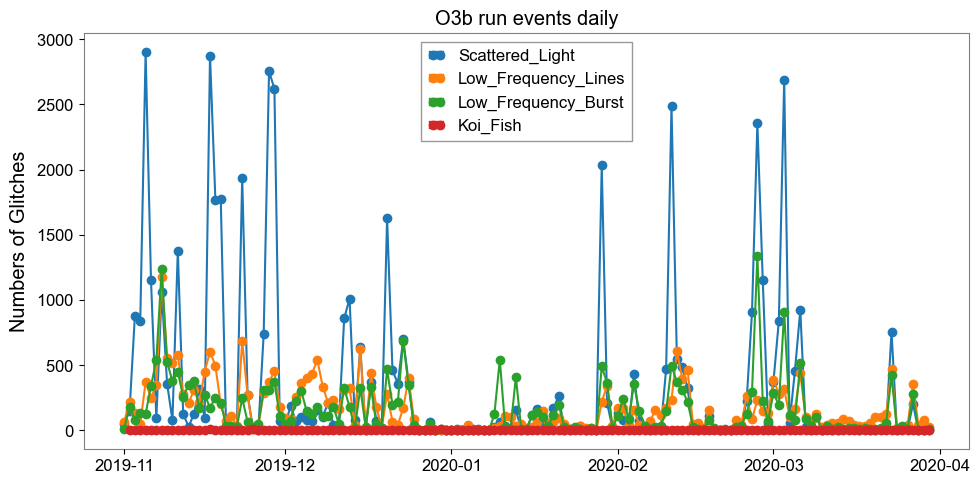

In [37]:
ff.plot_function(init_data_O3b, glitches_number, glitches_chosen, time_key, run='O3b')

## 4.2 Make the rate per time on data

Vamos pegar a quantidade de glitches em cada hora 'h' /dia 'd'/mes 'm' etc... Para cada glitch

In [40]:
gps_epoch = pd.Timestamp('1980-01-06 00:00:00', tz='UTC')

time_precision = 'h'      # intervalo de tempo para verificar a média (1h, 2h etc)
list_values = []

for i in range(glitches_number):
    
    df = init_data_O3a[init_data_O3a['label'] == glitches_chosen[i]].copy()
    df.index = gps_epoch + pd.to_timedelta(df['GPStime'], unit='s')

    values = df.resample(time_precision).size()
    list_values.append(values)

list_values[0].values

array([3, 0, 2, ..., 4, 5, 3], dtype=int64)

este resltado mostra quantos glitches '0', i.e., Scattering_Light, ocorreram a cada tempo 'h', i.e., horas.

este é o range de tempo (em 'h', i.e., horas) do nosso dataFrame

In [43]:
time = len(list_values[0])
time

4392

In [44]:
time/(24*7)

26.142857142857142

agora podemos plotar as curvas de cada glitch. O 'for' abaixo calcula 'time/n' médias (uma média por semana) para cada glitch, onde cada média é calculada entre os 'h' tempos dentro de cada semana 'time/n'.

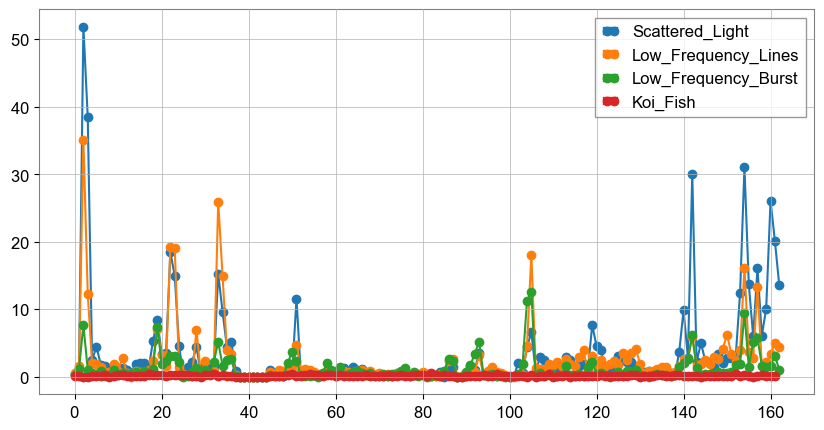

In [46]:
plt.figure(figsize=(10,5))

glitches_rates = []                    # usaremos esta lista posteriormente
for j in range(glitches_number):
    n = 27                          # o 'n' deve ser colocado na mesma medida do seu 'time_key'
    array = list_values[j]

    medias = [array[i:i+n].mean() for i in range(0, len(array), n)]
    glitches_rates.append(medias)
    
    plt.plot(medias, marker='o', linestyle='-', label=glitches_chosen[j])
    plt.legend()

## 4.3 phase space diagram (glitches number over some function f(t))

In [48]:
gps_epoch = pd.Timestamp('1980-01-06 00:00:00', tz='UTC')

# for i in range(glitches_number):

df = data[data['label'] == glitches_chosen[0]].copy()
df.index = gps_epoch + pd.to_timedelta(df['GPStime'], unit='s')

x_axis = df.resample('d').size()

time_utc = x_axis.index
Q = x_axis.values

NameError: name 'data' is not defined

agora precisamos passar os dados temporais de utc para GPStime

In [ ]:
from astropy.time import Time

# utc_time = Time('2020-03-01 12:00:00', scale='utc')

time_gps = Time(time_utc, scale='utc').gps

# gps_time = utc_time.gps
# gps_time

In [ ]:
plt.plot(time_gps, Q)

as taxas dos glitches foram armazenadas na lista **glitches_rates** dada anteriormente, enquanto que as quantidades de cada glitch são armazenadas em **glitches_numbers**, a seguir

## 4.4 Correlation matrix for similar visual glitches (we can automate this ?)

Para encontrar algumas relação matemática entre os glitches, vamos primeiro calcular sua taxa de aparição por hora (time_key = 'h'), para cada glitch:

In [ ]:
gps_epoch = pd.Timestamp('1980-01-06 00:00:00', tz='UTC')

matrix_values = []
for i in range(glitches_number):
    
    df = data[data['label'] == glitches_chosen[i]].copy()
    df.index = gps_epoch + pd.to_timedelta(df['GPStime'], unit='s')
    
    data_matrix = df.resample(time_key).size()
    matrix_values.append(data_matrix.values)

In [ ]:
matrix_values

este resltado mostra quantos glitches ocorreram a cada tempo 'h', i.e., horas, para todos glitches em 'glitches_chosen'

In [ ]:
x = matrix_values[0]
y = matrix_values[1]
z = matrix_values[2]
w = matrix_values[3]

df = pd.DataFrame([x, y, z, w]).T
df.columns = ['ScatLight', 'Low_Fr_Lin', 'Low_Fr_Bur', 'Koi_Fish']

corr_matrix = df.corr()
print(corr_matrix)

A correlação varia de -1 à 1. Quanto mais próxima das extremidades, maior é a correlação entre as classes (sendo máximamente correlacionadas diretamente em 1 e máximamente correlacionadas inversamente em -1), e quanto mais próxima de 0, menor correlacionadas estão as classes. Observe que a diagonal principal terá todos valores iguais a 1, pois qualquer classe está totalmente correlacionada com si mesma.

Por este resultado vemos que Scattering Light está cerca de 63% correlacionada à Low_Frequency Lines (curvas azuis e laranjas bem semelhantes), enquanto que apenas 1.4% inversamente correlacionada com Koi Fish (refletido pelas diferenças entre as curvas azuis e vermelhas)

**trash**

from gwpy.timeseries import TimeSeries
from scipy.fft import fft, ifft, fftfreq

In [ ]:
from scipy.fft import fft, fftfreq
import numpy as np
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [ ]:
data = {
    'x': [45, 37, 42, 35, 39],
    'y': [38, 31, 26, 28, 33],
    'z': [10, 15, 17, 21, 12]
}
dataframe = pd.DataFrame(data, columns=['x', 'y', 'z'])
print("Dataframe is : ")
print(dataframe)
matrix = dataframe.corr()
print("Correlation matrix is : ")
print(matrix)